In [1]:
import pandas as pd
from tqdm import tqdm
import os
import argparse
import warnings
from collections import Counter

In [2]:
from fz_data_crawler import scrape_google_play_reviews
from fz_text_preprocessor import preprocess
from fz_aspect_categorizer import categorize_review
from fz_fuzzy_sentiment_analyzer import FuzzySentimentAnalyzer
from fz_visualizer import plot_radar_chart, plot_dynamic_trend, plot_sentiment_distribution

In [3]:
# CONFIG
# Default
warnings.filterwarnings('ignore')
tqdm.pandas()
%matplotlib inline

# 1. Tentukan ID Aplikasi Target
APP_ID = 'app.bpjs.mobile'
JUMLAH_CRAWL = 100000 
DATA_FILE_PATH = f"{APP_ID}_reviews.csv"

# 2. 16 ASPEK KUNCI dan KATA KUNCINYA
ASPEK_KATA_KUNCI = {
    'UI/UX': ['tampilan', 'bingung', 'ribet', 'mudah', 'sederhana', 'desain', 'intuitif', 'menu', 'interface', 'ui'],
    'Multimedia': ['foto', 'gambar', 'video', 'kamera', 'suara', 'galeri', 'upload', 'kirim'],
    'User Requests': ['fitur', 'tambah', 'saran', 'request', 'mohon', 'semoga', 'perbaiki', 'tingkatkan', 'butuh', 'harus'],
    'Human Centric Issues': ['manusiawi', 'kebiasaan', 'pelayanan', 'cs', 'customer service', 'bantuan', 'layanan', 'admin', 'respon lambat', 'respon lama'],
    'Location Services': ['lokasi', 'gps', 'peta', 'maps', 'jarak', 'terdekat', 'di mana', 'mana'],
    'Resources': ['baterai', 'boros', 'ram', 'memori', 'penyimpanan', 'panas', 'berat', 'kuota', 'memori'],
    'Notification': ['notifikasi', 'notif', 'pemberitahuan', 'ganggu', 'terlalu banyak', 'tidak ada', 'pengingat', 'info', 'informasi'],
    'Advertising': ['iklan', 'ads', 'promo', 'banner', 'pop-up', 'mengganggu', 'spam'],
    'Compatibility': ['perangkat', 'device', 'os', 'android', 'versi', 'hp', 'compatible', 'support', 'dukungan'],
    'Updates': ['update', 'pembaruan', 'versi', 'perbarui'],
    'Stability': ['crash', 'bug', 'error', 'force close', 'berhenti', 'macet', 'freeze', 'hang', 'respon', 'eror'],
    'Payments': ['bayar', 'pembayaran', 'iuran', 'tagihan', 'topup', 'top up', 'transaksi', 'harga', 'biaya', 'mahal', 'murah', 'saldo', 'denda', 'va', 'virtual account'],
    'Connectivity': ['koneksi', 'jaringan', 'internet', 'wifi', 'offline', 'online', 'sinyal', 'loading'],
    'Privacy': ['privasi', 'keamanan', 'data', 'izin', 'akses', 'kontak', 'aman', 'pribadi', 'bocor'],
    'Login': ['login', 'logout', 'daftar', 'akun', 'verifikasi', 'otp', 'password', 'email', 'nomor hp', 'masuk', 'keluar'],
    'Uninstallation': ['uninstall', 'hapus', 'copot', 'ganti', 'pindah', 'kecewa', 'buang']
}

# 3. DAFTAR KATA SENTIMEN
POSITIVE_WORDS = ['bagus', 'puas', 'cepat', 'rekomendasi', 'keren', 'ramah', 'mudah', 'membantu', 'bermanfaat', 'terima kasih', 'mantap', 'baik', 'solusi', 'lancar', 'berhasil', 'hebat', 'sempurna']
NEGATIVE_WORDS = ['kecewa', 'lambat', 'lemot', 'rusak', 'buruk', 'jangan', 'mahal', 'sulit', 'susah', 'gagal', 'error', 'tidak bisa', 'tolong', 'parah', 'bingung', 'ribet', 'masalah', 'jelek', 'sampah', 'bohong']

In [4]:
# AKUISISI DAN PREPROCESSING DATA

def get_or_create_data(app_id, file_path, count):
    if os.path.exists(file_path):
        print(f"File data '{file_path}' sudah ada. Memuat data...")
        df = pd.read_csv(file_path, parse_dates=['date'])
    else:
        print(f"File data '{file_path}' tidak ditemukan atau kosong. Memulai proses crawling...")
        df = scrape_google_play_reviews(app_id=app_id, count=count)
        if not df.empty:
            df.to_csv(file_path, index=False)
            print(f"Data baru berhasil diambil dan disimpan di '{file_path}'.")
    return df

# Akuisisi
df = get_or_create_data(APP_ID, DATA_FILE_PATH, count=JUMLAH_CRAWL)

if not df.empty:
    # Preprocessing
    df.dropna(subset=['text'], inplace=True)
    tqdm.pandas(desc="Preprocessing Teks")
    df['processed_text'] = df['text'].progress_apply(preprocess)
    print("\nData setelah preprocessing:")
    display(df.head())

File data 'app.bpjs.mobile_reviews.csv' tidak ditemukan atau kosong. Memulai proses crawling...
Memulai proses crawling untuk 100000 ulasan dari aplikasi: app.bpjs.mobile.
Proses ini mungkin memakan waktu sangat lama, mohon bersabar...
Crawling selesai. Berhasil mengambil 100000 ulasan.
Data baru berhasil diambil dan disimpan di 'app.bpjs.mobile_reviews.csv'.


Preprocessing Teks: 100%|███████████| 100000/100000 [00:01<00:00, 50405.69it/s]



Data setelah preprocessing:


,date,rating,text,processed_text
0,2025-06-21 16:06:22,5,good,good
1,2025-06-21 16:04:24,5,Aplikasinya sdh canggih dan berdayaguna. perta...,aplikasinya sdh canggih berdayaguna pertahanka...
2,2025-06-21 15:54:21,5,mntap,mntap
3,2025-06-21 15:53:10,5,merubah faskes bener2 cepet,merubah faskes bener cepet
4,2025-06-21 15:48:18,5,okeh,okeh


In [5]:
# PERHITUNGAN BOBOT SECARA DINAMIS

def calculate_dynamic_weights(df, aspect_keywords):
    """
    Menghitung bobot aspek secara dinamis dari dataset.
    """
    print("Menghitung bobot aspek secara dinamis dari data...")
    all_detected_aspects = []
    for text in tqdm(df['processed_text'], desc="Menganalisis Frekuensi Aspek"):
        detected = categorize_review(text, aspect_keywords)
        all_detected_aspects.extend(detected)
    
    aspect_counts = Counter(all_detected_aspects)
    
    if 'Umum' in aspect_counts:
        del aspect_counts['Umum']
        
    total_counts = sum(aspect_counts.values())
    
    if total_counts == 0:
        print("Peringatan: Tidak ada aspek yang terdeteksi. Bobot tidak dapat dihitung.")
        return {}
        
    aspect_weights = {aspect: count / total_counts for aspect, count in aspect_counts.items()}
    
    return aspect_weights

if 'df' in locals() and not df.empty:
    ASPEK_BOBOT = calculate_dynamic_weights(df, ASPEK_KATA_KUNCI)
    
    print("\n--- Bobot Aspek yang Dihitung Secara Dinamis ---")
    bobot_df = pd.DataFrame(list(ASPEK_BOBOT.items()), columns=['Aspek', 'Bobot']).sort_values(by='Bobot', ascending=False)
    display(bobot_df.style.format({'Bobot': "{:.4f}"}))
    
    ASPEK_BOBOT['Umum'] = 0.0

Menghitung bobot aspek secara dinamis dari data...


Menganalisis Frekuensi Aspek: 100%|█| 100000/100000 [00:04<00:00, 20058.47it/s]



--- Bobot Aspek yang Dihitung Secara Dinamis ---


,Aspek,Bobot
1,Login,0.2779
8,UI/UX,0.1581
2,User Requests,0.0889
11,Compatibility,0.0866
0,Human Centric Issues,0.0548
9,Privacy,0.0529
7,Stability,0.0470
5,Connectivity,0.0417
3,Multimedia,0.0367
10,Uninstallation,0.0364


In [6]:
# EKSEKUSI DAN KLASIFIKASI

def classify_sentiment_5_level(score):
    """
    Mengklasifikasikan skor fuzzy menjadi 5 label sentimen.
    """
    if score > 75: return 'Sangat Positif'
    elif score > 56: return 'Positif'
    elif score > 44: return 'Netral'
    elif score > 25: return 'Negatif'
    else: return 'Sangat Negatif'

if 'df' in locals() and not df.empty:
    fuzzy_analyzer = FuzzySentimentAnalyzer(POSITIVE_WORDS, NEGATIVE_WORDS)

    results = []
    print("Mengkategorikan dan menganalisis sentimen per ulasan...")
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Analisis Fuzzy"):
        aspects = categorize_review(row['processed_text'], ASPEK_KATA_KUNCI)
        score = fuzzy_analyzer.analyze(row['processed_text'], row['rating'])
        for aspect in aspects:
            results.append({'date': row['date'], 'aspect': aspect, 'score': score, 'rating': row['rating']})
            
    df_results = pd.DataFrame(results)
    
    df_results['label_sentimen'] = df_results['score'].apply(classify_sentiment_5_level)
    
    print("\nAnalisis Selesai.")
    display(df_results.head())

Mengkategorikan dan menganalisis sentimen per ulasan...


Analisis Fuzzy: 100%|████████████████| 100000/100000 [01:06<00:00, 1497.09it/s]



Analisis Selesai.


,date,aspect,score,rating,label_sentimen
0,2025-06-21 16:06:22,Umum,75.0,5,Positif
1,2025-06-21 16:04:24,Human Centric Issues,75.0,5,Positif
2,2025-06-21 15:54:21,Umum,75.0,5,Positif
3,2025-06-21 15:53:10,Umum,75.0,5,Positif
4,2025-06-21 15:48:18,Umum,75.0,5,Positif


--- Distribusi Aspek Berdasarkan Rating Bintang ---


rating,1,2,3,4,5
aspect,,,,,
Advertising,28,7,8,7,8
Compatibility,5635,710,514,280,1469
Connectivity,2673,384,315,177,598
Human Centric Issues,1278,202,219,292,3461
Location Services,2519,355,265,115,356
Login,20277,2551,1777,851,2181
Multimedia,2992,337,171,52,94
Notification,1167,196,180,117,549
Payments,1267,140,121,87,336



--- Distribusi Sentimen Keseluruhan (berdasarkan penyebutan aspek) ---


,count
label_sentimen,
Sangat Negatif,70329
Positif,63517
Sangat Positif,5113
Netral,3954
Negatif,2722


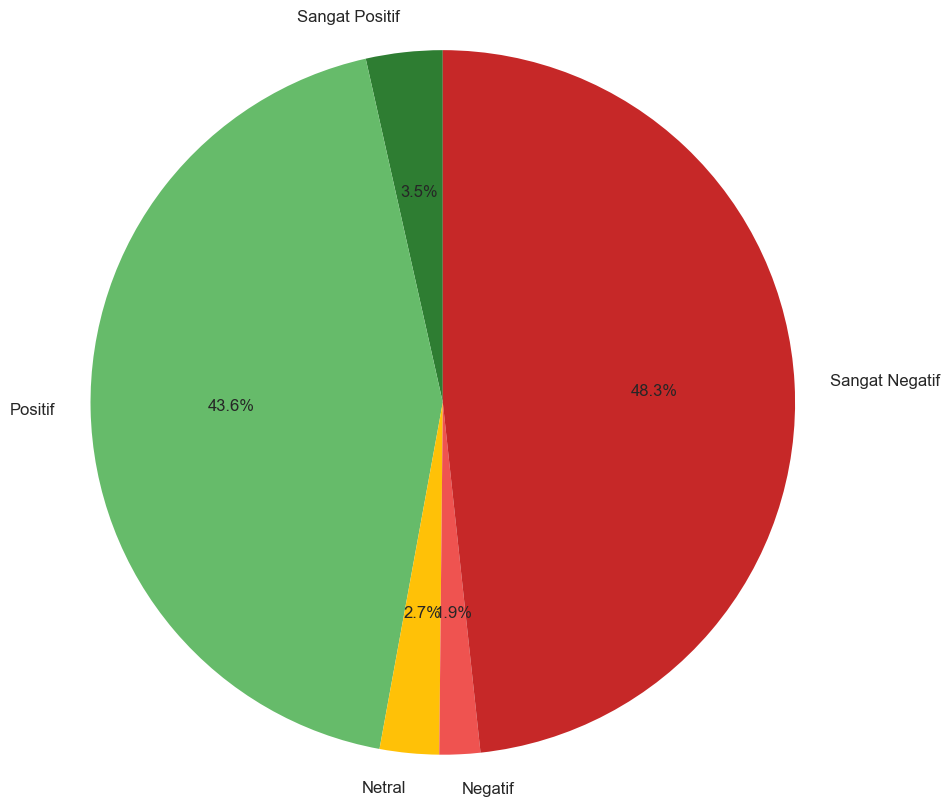

In [12]:
# ANALISIS DISTRIBUSI SENTIMEN

if 'df_results' in locals() and not df_results.empty:
    print("--- Distribusi Aspek Berdasarkan Rating Bintang ---")
    aspect_rating_distribution = df_results.groupby(['aspect', 'rating']).size().unstack(fill_value=0)
    display(aspect_rating_distribution)
    
    print("\n--- Distribusi Sentimen Keseluruhan (berdasarkan penyebutan aspek) ---")
    sentiment_distribution = df_results['label_sentimen'].value_counts()
    display(pd.DataFrame(sentiment_distribution))
    
    # Visualisasi pie chart
    plot_sentiment_distribution(sentiment_distribution, title=f"")

In [8]:
# AGREGASI DAN PERHITUNGAN BSC

if 'df_results' in locals() and not df_results.empty:
    # --- Analisis Dinamis ---
    print("Melakukan analisis dinamis...")
    df_results['periode'] = df_results['date'].dt.to_period('M').astype(str)
    dynamic_scores = df_results.groupby(['periode', 'aspect'])['score'].mean().unstack().fillna(0)

    weighted_scores = pd.DataFrame(index=dynamic_scores.index)
    for aspect, weight in ASPEK_BOBOT.items():
        if aspect in dynamic_scores.columns:
            weighted_scores[aspect] = dynamic_scores[aspect] * weight
            
    dynamic_scores['Skor_BSC_Total'] = weighted_scores.sum(axis=1)
    dynamic_scores['Interpretasi_Total'] = dynamic_scores['Skor_BSC_Total'].apply(classify_sentiment_5_level)
    
    print("\n--- Hasil Analisis Dinamis ---")
    display(dynamic_scores.round(2))

    # --- Analisis Statis ---
    static_scores_series = df_results.groupby('aspect')['score'].mean()
    if 'Umum' in static_scores_series:
        static_scores_series = static_scores_series.drop('Umum')
    
    static_scores_df = pd.DataFrame(static_scores_series).rename(columns={'score': 'Skor Rata-rata'})
    # Menambahkan kolom interpretasi sentimen
    static_scores_df['Interpretasi Sentimen'] = static_scores_df['Skor Rata-rata'].apply(classify_sentiment_5_level)
    
    print("\n--- Hasil Analisis Statis ---")
    display(static_scores_df.sort_values(by='Skor Rata-rata', ascending=False).round(2))

Melakukan analisis dinamis...

--- Hasil Analisis Dinamis ---


aspect,Advertising,Compatibility,Connectivity,Human Centric Issues,Location Services,Login,Multimedia,Notification,Payments,Privacy,Resources,Stability,UI/UX,Umum,Uninstallation,Updates,User Requests,Skor_BSC_Total,Interpretasi_Total
periode,,,,,,,,,,,,,,,,,,,
2023-11,50.00,32.48,38.58,53.03,30.09,31.14,30.55,40.55,39.11,39.90,39.89,29.11,51.59,65.08,31.56,29.43,40.81,37.61,Negatif
2023-12,20.61,37.17,35.50,59.11,33.19,31.90,27.94,42.18,36.14,46.71,39.03,33.53,60.17,67.14,39.77,32.85,45.09,41.10,Negatif
2024-01,34.85,36.64,33.62,61.32,33.91,30.73,26.98,41.61,38.60,48.65,41.01,35.43,62.47,67.60,38.78,35.24,42.80,41.22,Negatif
2024-02,0.00,39.45,38.19,63.73,31.38,34.73,27.18,42.70,44.05,54.75,47.07,35.70,62.43,69.42,47.14,37.19,49.37,44.26,Netral
2024-03,31.76,36.83,38.54,62.66,35.63,31.16,27.89,36.23,38.40,52.99,47.81,34.64,60.52,68.49,39.83,40.04,43.48,41.80,Negatif
2024-04,25.00,38.59,40.61,62.01,34.29,32.48,27.94,40.12,36.23,57.12,46.10,33.33,61.34,69.51,43.00,42.22,47.30,43.15,Negatif
2024-05,62.59,36.19,39.05,61.50,35.26,32.49,28.69,40.79,42.54,50.52,51.27,32.26,61.16,69.77,42.61,38.98,45.98,42.48,Negatif
2024-06,25.00,35.15,37.42,58.35,32.03,31.74,27.03,36.32,37.13,49.53,55.03,31.15,59.43,69.78,39.93,37.07,46.42,41.09,Negatif
2024-07,25.00,34.49,33.26,57.59,32.38,31.35,27.28,39.89,39.21,48.19,48.21,32.18,54.41,69.54,38.29,34.41,43.63,39.57,Negatif



--- Hasil Analisis Statis ---


,Skor Rata-rata,Interpretasi Sentimen
aspect,,
Human Centric Issues,59.92,Positif
UI/UX,56.22,Positif
Privacy,47.76,Netral
Resources,44.98,Netral
User Requests,43.53,Negatif
Notification,41.43,Negatif
Advertising,40.11,Negatif
Uninstallation,37.42,Negatif
Payments,36.52,Negatif


Membuat visualisasi Scorecard...


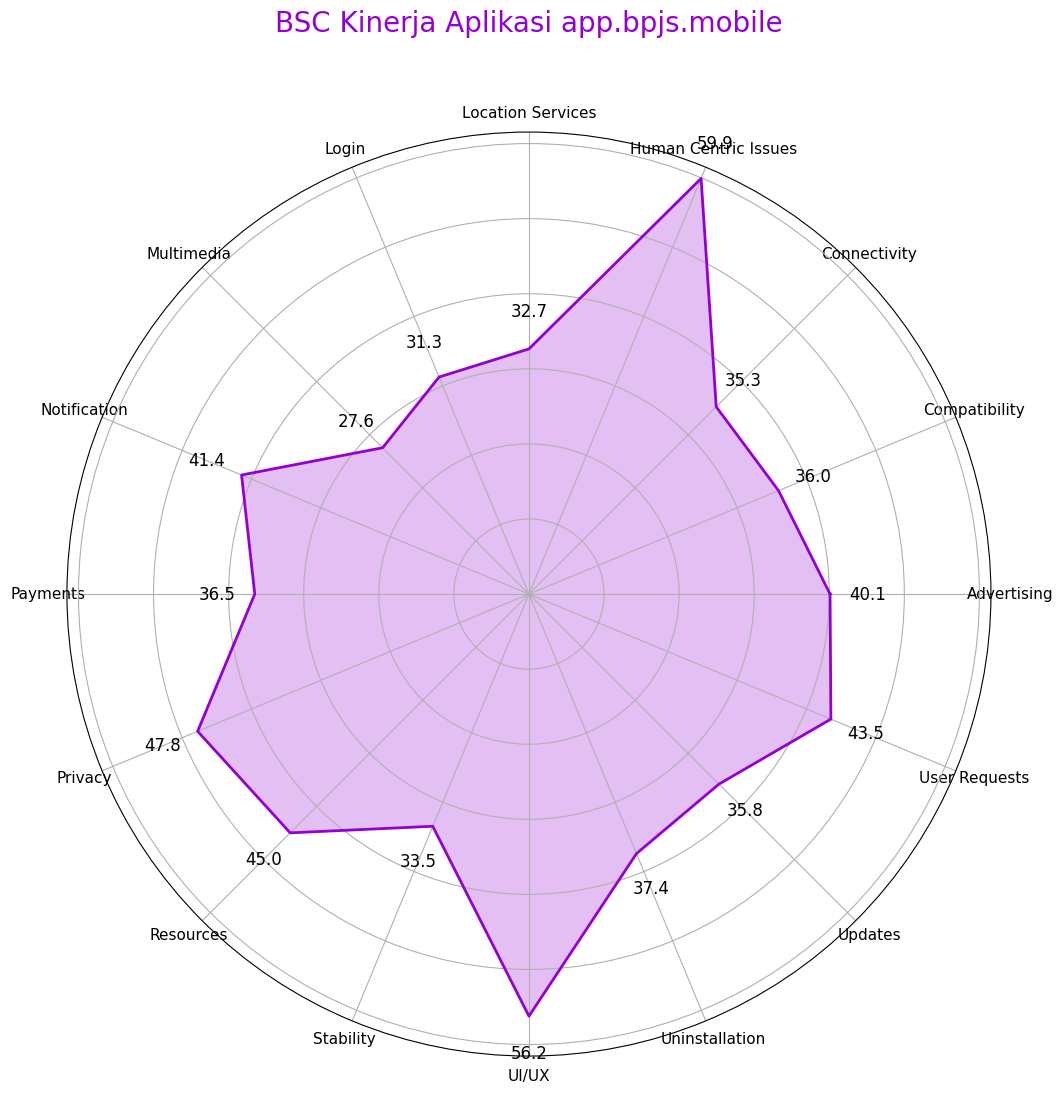

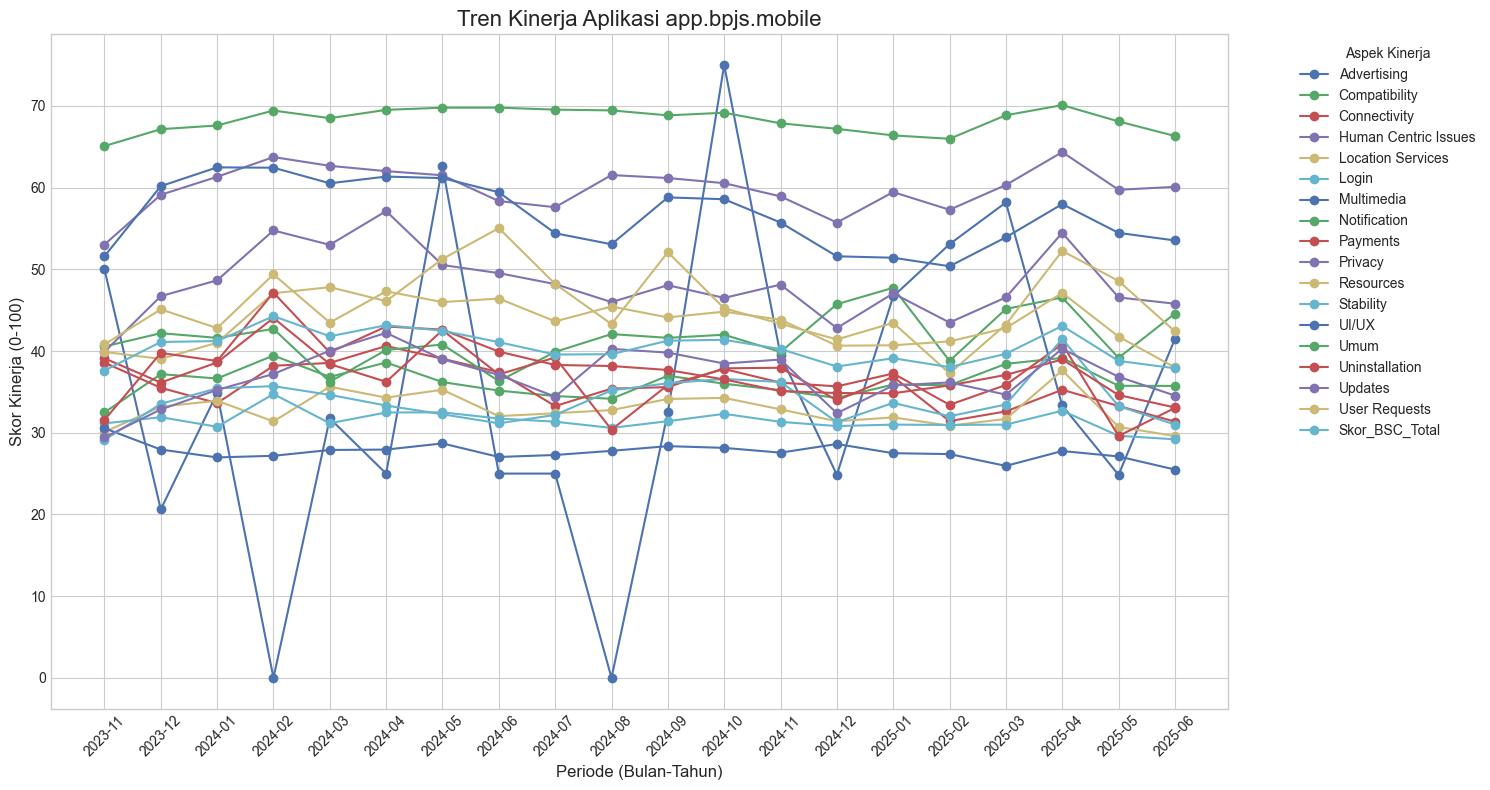


--- Proses Selesai ---


In [9]:
# VISUALISASI BSC

if 'static_scores_df' in locals() and not static_scores_df.empty:
    print("Membuat visualisasi Scorecard...")
    plot_radar_chart(static_scores_series.to_dict(), title=f"BSC Kinerja Aplikasi {APP_ID}")
    plot_dynamic_trend(dynamic_scores.drop(columns=['Interpretasi_Total']), title=f"Tren Kinerja Aplikasi {APP_ID}")
    
    print("\n--- Proses Selesai ---")